# 1. Import and Install Dependencies

In [3]:
# !pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib #run once

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. MP Holistic Keypoints

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections #FACEMESH_TESSELATION
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, #FACEMESH_TESSELATION
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        cv2.waitKey(5000)
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        # if cv2.waitKey(10) & 0xFF == ord('q'):
        if cv2.waitKey(10000):
            break
    cap.release()
    cv2.destroyAllWindows()

    # to close camera capture, click q on keyboard

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [9]:
draw_landmarks(frame, results)

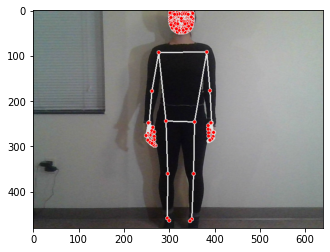

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Coordinate Values

In [11]:
print(len(results.left_hand_landmarks.landmark))
print(len(results.right_hand_landmarks.landmark))
print(len(results.pose_landmarks.landmark))
print(len(results.face_landmarks.landmark))

21
21
33
468


In [22]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [23]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [24]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [25]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [26]:
result_test = extract_keypoints(results)

In [21]:
result_test

array([ 5.11939824e-01,  3.84221412e-02, -4.11136448e-01, ...,
        4.10692841e-01,  6.11488104e-01,  2.16144996e-04])

In [27]:
np.save('0', result_test)

In [28]:
np.load('0.npy')

array([ 5.11939824e-01,  3.84221412e-02, -4.11136448e-01, ...,
        4.10692841e-01,  6.11488104e-01,  2.16144996e-04])

# 4. Setup Data Collection Folders

In [29]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect - the 8 full body exercises
actions = np.array(['Cross Jacks', 'Walking Lunges', 'Bent Over Twists', 'Side to Side Hops', 
                    'Run in Place', 'Side to Side Shuffle', 'Arm Cross Side Lunges', 'Scissor Skier']) 

# Thirty videos worth of data per action/exercise
no_sequences = 30

# Each video will be 30 frames long
sequence_length = 30

# Folder start
start_folder = 30

In [30]:
#run this first to set up folders
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [59]:
# run this on existing folders
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass
        

# 5. Collect Keypoint Values for Training and Testing

In [32]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, '{} STARTING COLLECTION'.format(action), (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [33]:
cap.release()
cv2.destroyAllWindows()

In [56]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, '{} STARTING'.format(action), (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [34]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [85]:
# change actions as needed 
actions = np.array(['Cross Jacks', 'Bent Over Twists', 'Side to Side Hops', 
                    'Run in Place', 'Side to Side Shuffle', 'Arm Cross Side Lunges']) 

In [86]:
label_map = {label:num for num, label in enumerate(actions)}

In [87]:
label_map

{'Cross Jacks': 0,
 'Bent Over Twists': 1,
 'Side to Side Hops': 2,
 'Run in Place': 3,
 'Side to Side Shuffle': 4,
 'Arm Cross Side Lunges': 5}

In [88]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [89]:
np.array(sequences).shape

(360, 30, 1662)

In [90]:
np.array(labels).shape

(360,)

In [91]:
X = np.array(sequences)

In [92]:
X.shape

(360, 30, 1662)

In [93]:
y = to_categorical(labels).astype(int)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [95]:
y_test.shape

(18, 6)

# 7. Build and Train LSTM Neural Network

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [112]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [150]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [151]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [119]:
model.fit(X_train, y_train, epochs=70, callbacks=[tb_callback])

Epoch 1/70
11/11 [==============================] - 3s 52ms/step - loss: 13.3775 - categorical_accuracy: 0.1550
Epoch 2/70
11/11 [==============================] - 1s 54ms/step - loss: 12.7998 - categorical_accuracy: 0.1988
Epoch 3/70
11/11 [==============================] - 1s 54ms/step - loss: 4.8017 - categorical_accuracy: 0.2047
Epoch 4/70
11/11 [==============================] - 1s 53ms/step - loss: 2.3490 - categorical_accuracy: 0.2749
Epoch 5/70
11/11 [==============================] - 1s 55ms/step - loss: 2.0268 - categorical_accuracy: 0.2544
Epoch 6/70
11/11 [==============================] - 1s 54ms/step - loss: 1.7640 - categorical_accuracy: 0.2602
Epoch 7/70
11/11 [==============================] - 1s 55ms/step - loss: 1.5944 - categorical_accuracy: 0.3538
Epoch 8/70
11/11 [==============================] - 1s 54ms/step - loss: 1.5576 - categorical_accuracy: 0.3538
Epoch 9/70
11/11 [==============================] - 1s 54ms/step - loss: 1.4574 - categorical_accuracy: 0.3977

In [120]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_22 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 6)                 198       
                                                                 
Total params: 596,774
Trainable params: 596,774
Non-tr

# 8. Make Predictions using Model

In [121]:
res = model.predict(X_test)

In [122]:
actions[np.argmax(res[4])]

'Bent Over Twists'

In [123]:
actions[np.argmax(y_test[4])]

'Bent Over Twists'

In [140]:
actions[np.argmax(res[0])]

'Side to Side Shuffle'

In [141]:
actions[np.argmax(res[0])]

'Side to Side Shuffle'

# 9. Save Weights

In [124]:
model.save('action.h5')
# tensorboard --logdir=. in command line to get local host and see accuracy of model

In [149]:
del model

In [152]:
# first call model build (seq) and compile model
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [142]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [164]:
yhat = model.predict(X_test)

In [165]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [167]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[15,  0],
        [ 0,  3]],

       [[15,  0],
        [ 0,  3]],

       [[11,  1],
        [ 0,  6]],

       [[15,  0],
        [ 1,  2]],

       [[16,  0],
        [ 0,  2]],

       [[17,  0],
        [ 0,  1]]], dtype=int64)

In [168]:
yhat #represent classes

[4, 4, 1, 5, 1, 2, 2, 0, 3, 2, 0, 1, 3, 2, 2, 2, 0, 2]

In [169]:
accuracy_score(ytrue, yhat)

0.9444444444444444